In [160]:
THRES = 10

In [161]:
ASN_TO_NAME = dict()
for l in open("asn.txt","r").readlines():
    name, asn = l.strip().split(" ")
    ASN_TO_NAME[asn] = name

In [162]:
from collections import defaultdict, deque
from datetime import datetime
from enum import Enum
from ipaddress import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [139]:
class DataManager:
    def __init__(self, filename):
        self.data = defaultdict(lambda: defaultdict(list))
        self.softbank = []
        self.au_v4 = []
        self.au_v6 = []
        self.au_not = [convert("106.135.0.0/16")]
        self.load(filename)
        
    def load(self, filename):
        f = open("sb-mobile-1.txt",'r') 
        for subnet in f.readlines():
            self.softbank.append(convert(subnet.strip()))
        f.close()
        
        f = open("au-mobile-1.txt",'r') 
        for subnet in f.readlines():
            if ":" in subnet:
                self.au_v6.append(convert(subnet.strip()))
            else:
                self.au_v4.append(convert(subnet.strip()))
        f.close()
        
        f = open(f"{filename}", "r")
        for line in f.readlines()[1:] :
            self.process_line(line.strip())
        f.close()
                
    def process_line(self, line):
        split = list(line.strip().split(","))
        if len(split) > 7 :
            date_time, mean, _, _, ip = split[:5]
            city = ",".join(split[5:-1])
            asn = split[-1]
        else :    
            date_time, mean, _, _, ip, _, asn = split
        
        if asn == "17676" and ":" not in ip and contain(ip, self.softbank) :
            asn = asn+'-cell'
        if asn == "2516":
            if ":" in ip and contain(ip, self.au_v6) :
                asn = asn+'-cell'
            if ":" not in ip and contain(ip, self.au_v4):
                asn = asn+'-cell'
        self.data[asn][date_time].append( (float(mean), ip) )
        

In [132]:
def find_median(data):
    n = len(data)
    if n < THRES :
        return -1
    data.sort()
    return data[n//2][0] if n%2 else (data[n//2-1][0]+data[n//2][0])/2

In [133]:
def build_datetime(dt):
    month, day, year_hour = dt.split("/")
    year, hour = year_hour.split(" ")
    return datetime(int(year), int(month), int(day), int(hour))

def get_index(_dt, _st):
    dt = build_datetime(_dt)
    st = build_datetime(_st)
    return int((datetime.timestamp(dt)-datetime.timestamp(st))//3600)

In [103]:
def build_plot_data(data, st, end):
    x, y = [], []
    for dt in sorted(data.keys()) :
        if dt < st or dt > end:
            continue
        median = find_median(data[dt])
        if median == -1 :
            continue
        x.append(get_index(dt, st))
        y.append(median)
    return  np.array(x),  np.array(y)

In [104]:
def build_plot_data_average_by_day(data, st, end):
    x, y = [], []
    group = defaultdict(list)
    for dt in data.keys():
        if dt < st or dt > end:
            continue
        group_name, _ = dt.split(" ")
        group[group_name].append(dt)
    for g in sorted(group.keys()):
        c = 0
        v = 0
        for dt in group[g]:
            temp = [ x[0] for x in data[dt] ]
            c += len(temp)
            v += sum(temp)
        if c!=0:
            x.append( get_index(g+" 00", st) )
            y.append( v/c )
    return  np.array(x),  np.array(y)

In [105]:
def build_plot_data_median_by_day(data, st, end):
    x, y = [], []
    group = defaultdict(list)
    for dt in data.keys():
        if dt < st or dt > end:
            continue
        group_name, _ = dt.split(" ")
        group[group_name].append(dt)
        
    for g in sorted(group.keys()):
        temp = []
        for dt in group[g]:
            temp += [ x[0] for x in data[dt] ]
        temp.sort()
        n = len(temp)
        if n != 0 :
            x.append( get_index(g+" 00", st) )
            y.append( temp[n//2] if n%2 else (temp[n//2]+temp[n//2-1])/2 )
            
    return  np.array(x),  np.array(y)

In [106]:
def build_bucket(data, st, end):
    size = get_index(end, st)+1
    bucket = [0]*size
    for dt in data:
        if dt < st or dt > end:
            continue
        bucket[get_index(dt, st)] = find_median(data[dt])
    return bucket    
    
def build_plot_data_smooth(data, st, end):
    x, y = [], []
    p = 24
    c = v = 0 
    bucket = build_bucket(data,st,end)
    for i in range(p-1):
        c += 1 if bucket[i] != 0 else 0
        v += bucket[i]
    
    for i in range(p-1, len(bucket)):
        c += 1 if bucket[i] != 0 else 0
        v += bucket[i]
        
        x.append(i-p+1)
        _y = 0 if c == 0 else v/c
        y.append(_y)
    
        c -= 1 if bucket[i-p+1] != 0 else 0
        v -= bucket[i-p+1]
    
    return  np.array(x),  np.array(y)

In [107]:
def get_xticklabels(xticks, st, fmt):
    ref = build_datetime(st)
    ts_ref = datetime.timestamp(ref)
    xticklabels = []
    for t in xticks:
        dt = datetime.fromtimestamp(ts_ref+t*3600)
        xticklabels.append(dt.strftime(fmt))
    return xticklabels

In [134]:
def plot(data, st, end, title):
    fig = plt.figure(figsize=(30,4), dpi=110)
    ax = fig.add_subplot(111)
    x, y = data['build'](data['data'], st, end)
    median = get_median_between(data['data'], data['build'])
#     median = 10
    
    xticks = list(range(x[0],x[-1],24*7))
    xticklabels = get_xticklabels(xticks, st, "%h %d")
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    ax.set_ylabel("Throughput (MBpS)")
    ax.set_xlabel("Date")
    ax.set_ylim(0, median*2.5)
    ax.grid()
    
    ax.axhline(median, ls= '--',color='grey', lw=2, alpha=0.9)  
    ax.plot(x,y,"-", color='black')    
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(x, y, median, where=y > median, facecolor='lightblue', interpolate=True)
    ax.fill_between(x, y, median, where=y < median, facecolor='red', alpha=0.4, interpolate=True)
    
    fig.savefig(f"img/cell/{title}.png")

In [109]:
def get_median_between(data, func, st='01/01/2020 00', end='03/01/2020 00'):
    x, y = func(data, st, end)
    y.sort()
    n = len(y)
    result = y[n//2] if (n%2) else (y[n//2-1]+y[n//2])/2
    return result

In [158]:
def plot_worst_week(data, st, end, title):
    x, y = data['build'](data['data'],st,end)
    median = get_median_between(data['data'], data['build'])
    
    period = 24*14
    res = -1
    
    dq = deque()
    st_idx = 0
    end_idx = get_index(end, st)
    i = bad_index = worst_index = 0
    while st_idx+period < end_idx:
        while dq and dq[0][0] < st_idx:
            if dq[0][1] < median:
                bad_index -= 1
            dq.popleft()
        
        while i < len(x) and x[i] <= st_idx+period:
            dq.append((x[i], y[i],i))
            if y[i] < median:
                bad_index += 1
            i += 1
        
        if bad_index > worst_index:
            worst_index = bad_index
            res = [dq[0][2],dq[-1][2]]
        
        st_idx += 1
#         print(st_idx, res,  bad_index, median)
    fig = plt.figure(figsize=(30,4), dpi=110)
    ax = fig.add_subplot(111)
    x = x[res[0]:res[1]+1]
    y = y[res[0]:res[1]+1]
    
    xticks = list(range(x[0],x[-1],12))
    xticklabels = get_xticklabels(xticks, st, "%H:%M\n%h %d")
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    ax.set_ylabel("Throughput (MBpS)")
    ax.set_xlabel("Date")
    ax.grid()
    
    ax.axhline(median, ls= '--',color='grey', lw=2, alpha=0.9)  
    ax.plot(x,y,"-", color='black')    
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(x, y, median, where=y > median, facecolor='lightblue', interpolate=True)
    ax.fill_between(x, y, median, where=y < median, facecolor='red', alpha=0.4, interpolate=True)
    
    fig.savefig(f"img/cell-worst/{title}.png")    

In [140]:
# bq = DataManager("bq-full.csv")

In [150]:
ASN_TO_NAME= {
    '2516-cell': 'KDDI-cell',
    '17676-cell': 'SOFTBANK-cell',
    '2516': 'KDDI',
    '17676': 'SOFTBANK', 
    '9605': 'DOCOMO', 
    '4713': 'NTT' 
}

2516-cell
17676-cell
2516
17676
9605
4713


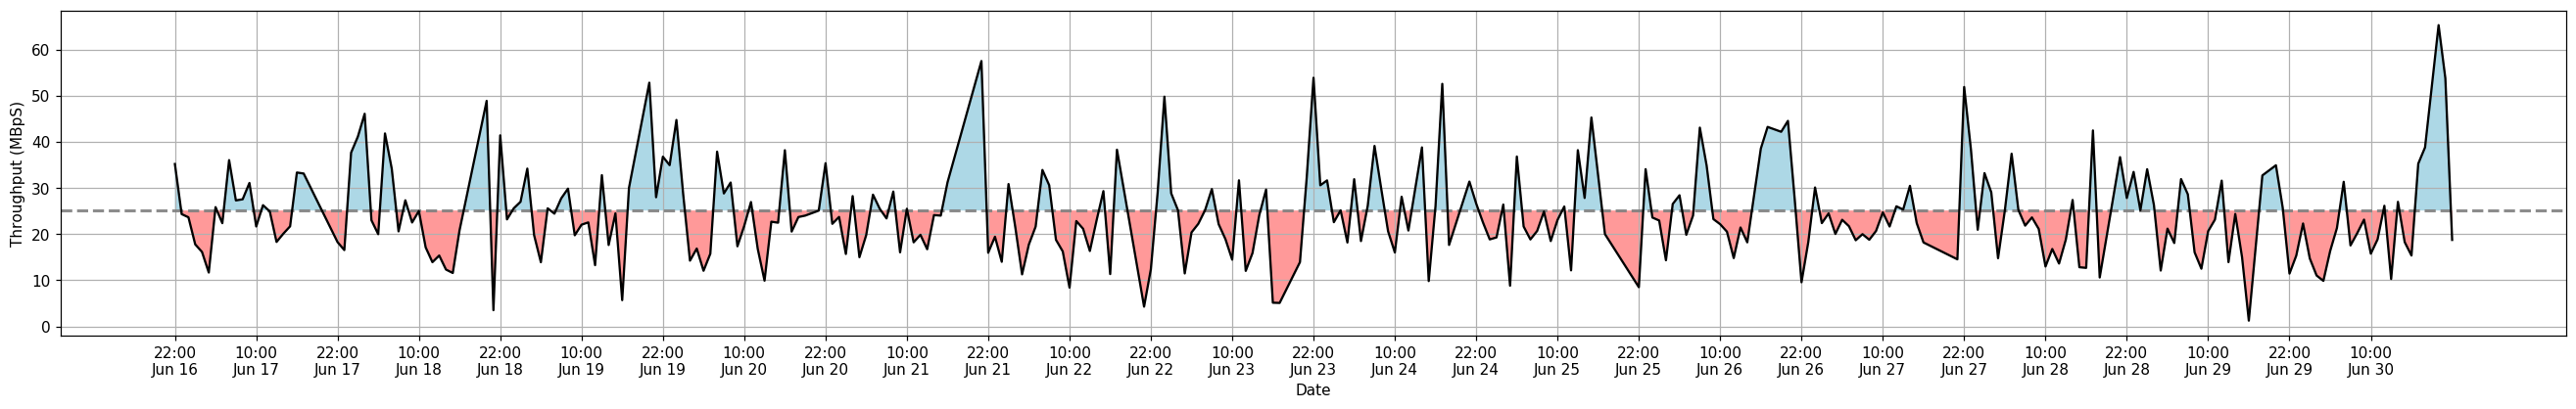

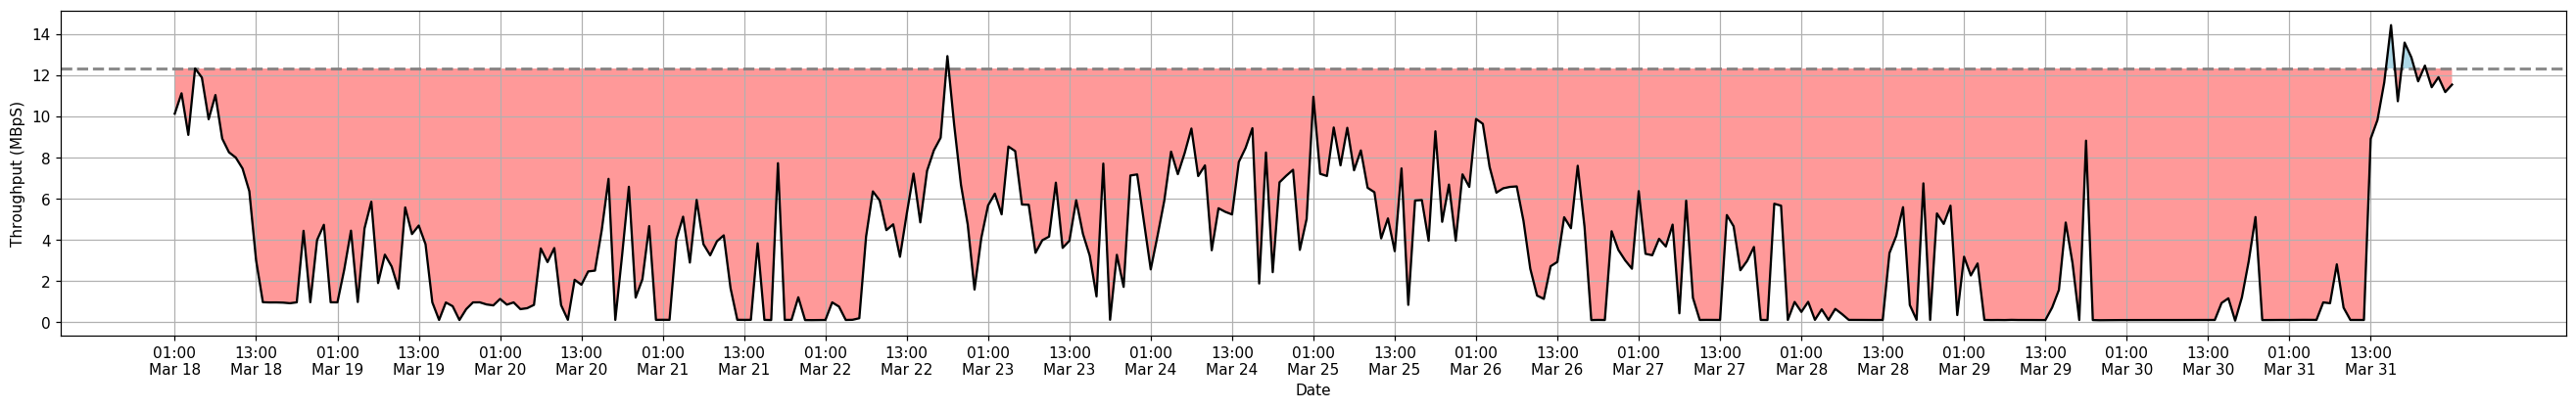

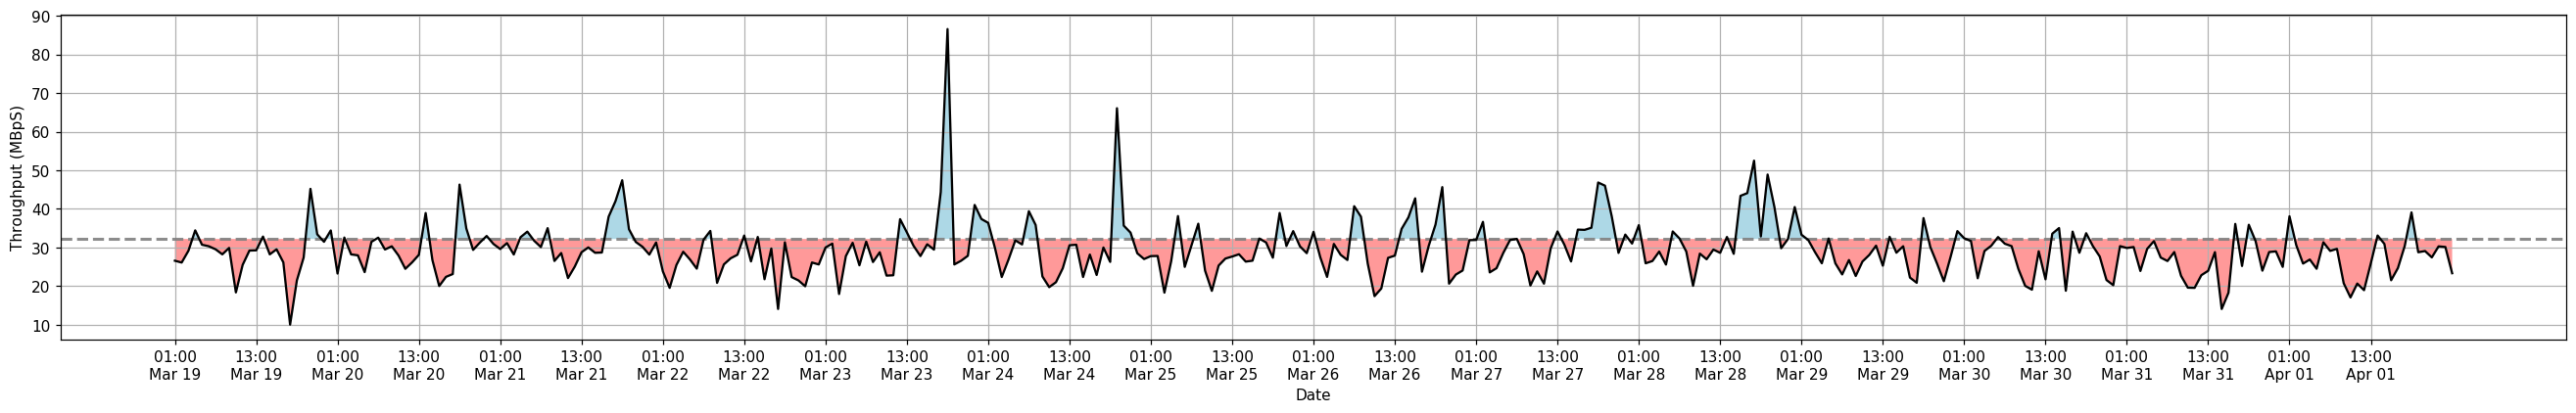

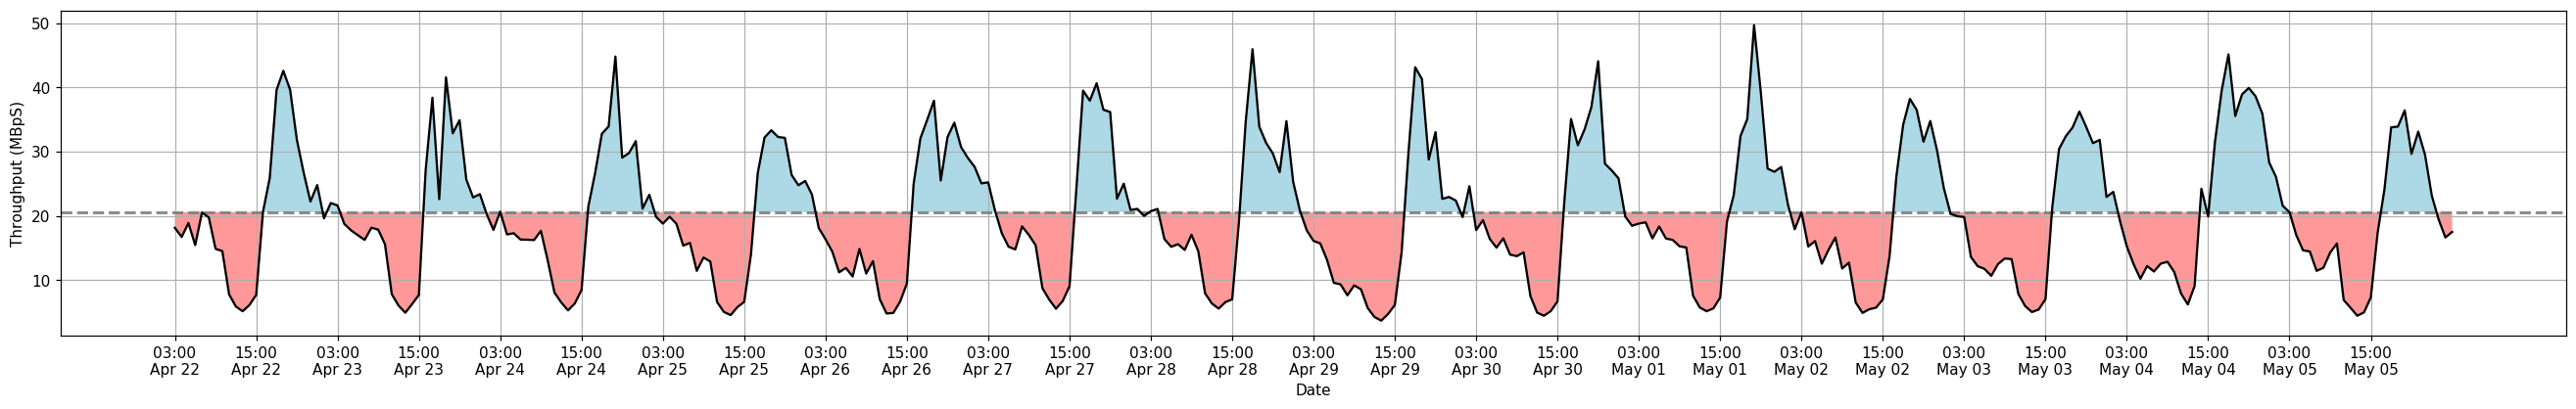

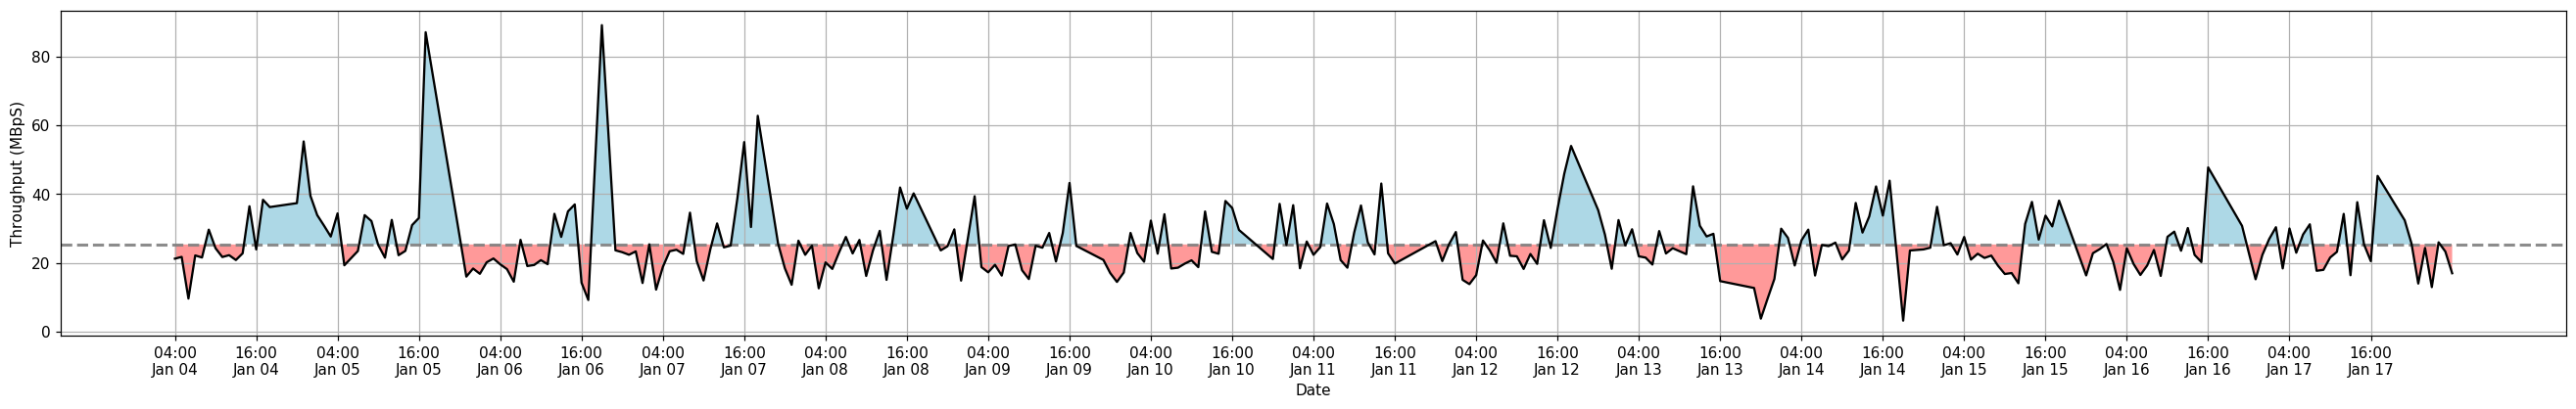

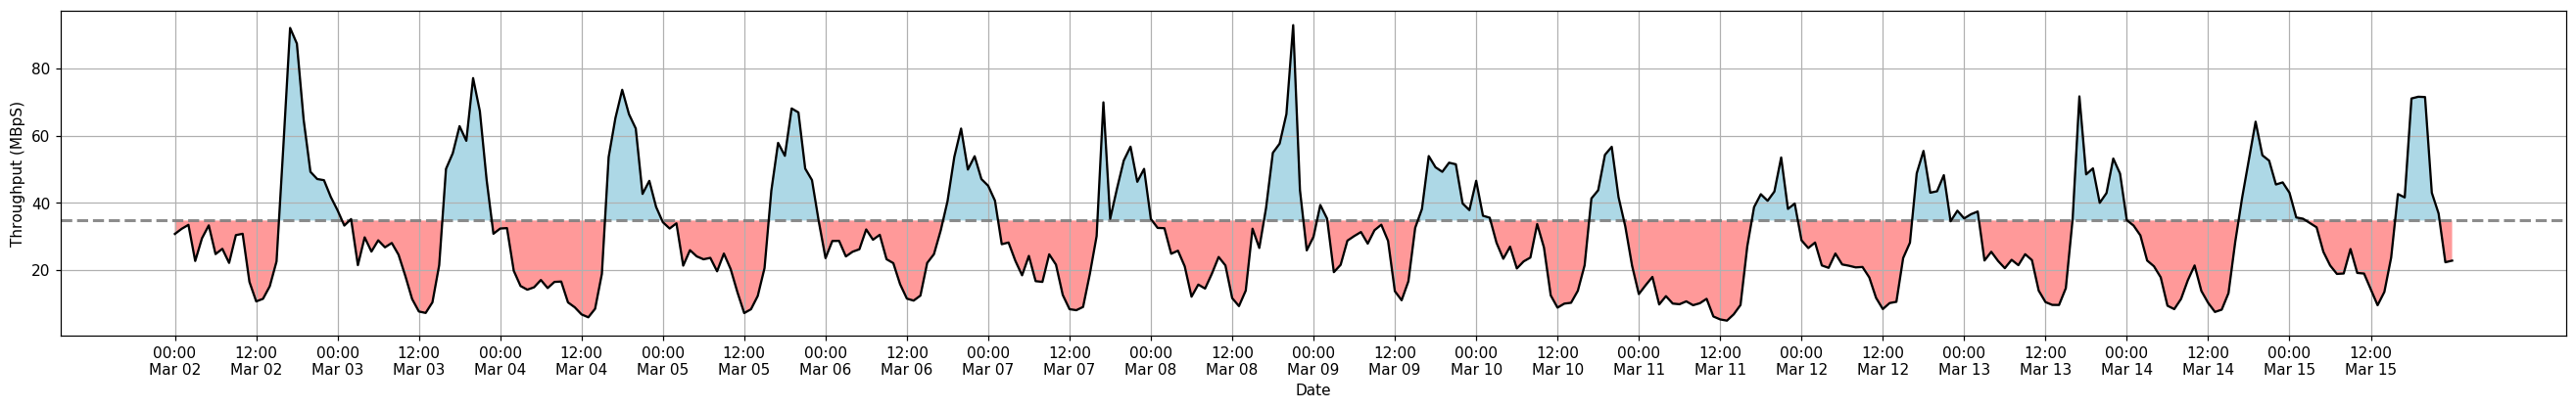

In [159]:
for asn in ASN_TO_NAME :
    data = {
        'data': bq.data[asn],
        'build': build_plot_data
    }
    print(asn)
#     plot(data, '01/01/2020 00', '02/29/2020 23', f"{ASN_TO_NAME[asn]}-{asn}-Jan-Feb-full")
#     plot(data, '03/01/2020 00', '04/30/2020 23', f"{ASN_TO_NAME[asn]}-{asn}-Mar-Apr-full")
#     plot(data, '05/01/2020 00', '06/30/2020 23', f"{ASN_TO_NAME[asn]}-{asn}-May-Jun-full")
    plot_worst_week(data, '01/01/2020 00', '06/30/2020 23', f"{ASN_TO_NAME[asn]}-{asn}-worst-2-weeks")

In [84]:
mapper = {
    '0':'0000', '1':'0001', '2':'0010', '3': '0011', 
    '4':'0100', '5':'0101', '6':'0110', '7': '0111', 
    '8':'1000', '9':'1001', 'a':'1010', 'b': '1011', 
    'c':'1100', 'd':'1101', 'e':'1110', 'f': '1111'
}
def _convert(v):
    arr = []
    while v>0:
        arr.append(str(v%2))
        v//=2
    return "".join(arr[::-1]).rjust(8,'0')

def convert(subnet):
    ip, m = subnet.split("/")
    mask = int(m)
    if ":" in ip :
        a = "".join(list(map(lambda x: x.rjust(4,'0'), ip.split(":"))))
        i = 0
        code = ""
        while len(code) < mask :
            code = code + mapper[a[i]]
            i += 1
        return (code[:mask], mask)
    else :
        code = ""
        for slot in ip.split("."):
            code = code + _convert(int(slot))
        return (code[:mask], mask)

In [85]:
def v4_convert(ip):
    code = ""
    for slot in ip.split("."):
        code = code + _convert(int(slot))
    return code

def contain (v, subnets):
    if ":" not in v :
        ip = v4_convert(v)
    else :
        ip = ""
        a = "".join(list(map(lambda x: x.rjust(4,'0'), v.split(":"))))
        for i in range(9):
            ip = ip + mapper[a[i]]

    for binary, l in subnets:
        if ip[:l] == binary:
            return True
        
    return False